## Modélisation de la régression logistique

In [66]:
# import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [67]:
# import du dataset
dataset = pd.read_csv('sba_national_clean.csv')

### Constitution du train/test

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
# suppression des variables non-nécessaires pour le modèle
dataset = dataset.drop(['LoanNr_ChkDgt','Name','City','Zip','Bank','ApprovalDate','ApprovalFY','ChgOffDate','DisbursementDate','DisbursementGross','BalanceGross','ChgOffPrinGr','SBA_Appv'],axis=1)

Travailler sur les variables 'NoEmp', 'ApprovalDate', 'ApprovalFY'

In [70]:
dataset.sample(1)

,State,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,crysis_year
333849,AZ,IL,62,240,3,2,0,0,0,0,1,1,1,112500.0,no


In [71]:
# Séparation du dataset en dataset d'entrainement et de test
X = dataset.drop("MIS_Status", axis=1)
y = dataset["MIS_Status"]

# test_size de 10% puisque beaucoup de données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Pipeline

In [72]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [73]:
# Identification des variables numériques et catégorielles pour le preproccessing
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [74]:

# Pipeline pour le preproccessing des variables numériques
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Imputation des valeurs manquantes
    ('scaler', StandardScaler())  # Normalisation des données numériques
])

# Pipeline pour le preproccessing des données catégorielles
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des valeurs manquantes
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encodage des variables catégorielles
])

# Combinaison des deux pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Création de la pipeline finale avec le preproccessing et modèle de régression logistique avec équilibrage des classes prédites
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

In [75]:
# Entraînement du modèle
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['State', 'BankState', 'crysis_year'], dtype='object'))])),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [76]:
# Prédictions sur le jeu de test
y_pred = pipeline.predict(X_test)

### Evaluation du modèle

In [77]:
# Evaluation de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy : {accuracy}')

accuracy : 0.7421503171082403


In [78]:
# Evaluation avec le AUC-ROC (analyse globale des performances)
auc_roc= roc_auc_score(y_test, y_pred)
print(f"auc_roc_score = {auc_roc}")

auc_roc_score = 0.7730232678861284


In [79]:
from sklearn.metrics import roc_curve, auc

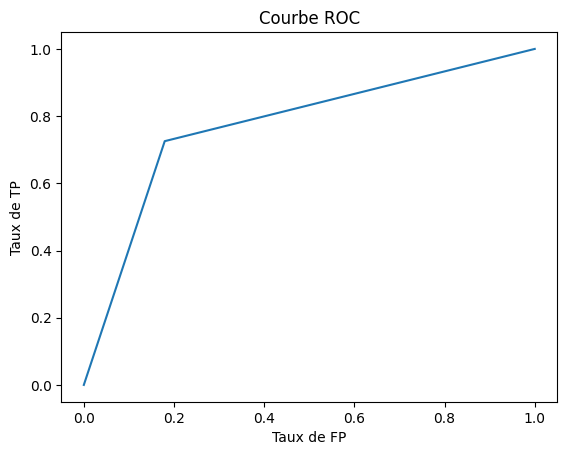

In [80]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("Taux de FP")
plt.ylabel("Taux de TP")
plt.title("Courbe ROC")
plt.show()

In [81]:
# Évaluation avec les métriques recall, precision et f1-score
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.82      0.53     31454
           1       0.95      0.73      0.82    147980

    accuracy                           0.74    179434
   macro avg       0.67      0.77      0.68    179434
weighted avg       0.85      0.74      0.77    179434



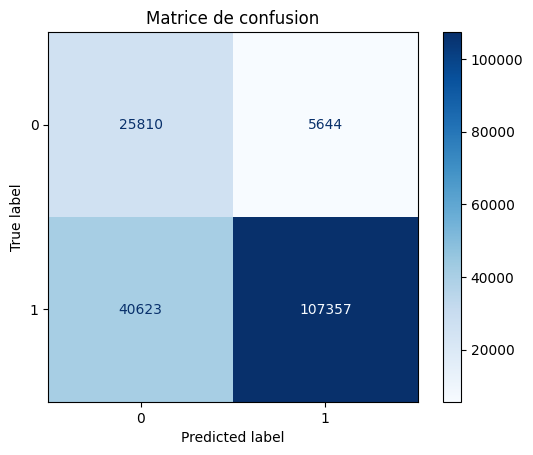

In [82]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title('Matrice de confusion')
plt.show()

In [83]:
# score Log-Loss (évaluation de la qualité des probabilités prédites)
from sklearn.metrics import log_loss

print(f'Log-Loss: {log_loss(y_test, y_pred)}')

Log-Loss: 9.293844596644355


### Implémentation du modèle XGBOOST

In [84]:
from xgboost import XGBClassifier

In [85]:
# Création de la pipeline finale avec le preproccessing et modèle de boosting
pipeline_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators = 2, max_dept=2, learning_rate=1, objective='binary:logistic'))  # Régression logistique
])

In [86]:
# Entrainement du modèle xgboost avec les données d'entrainement
pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='mos...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_dept=2, max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=2, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [87]:
y_pred2 = pipeline_2.predict(X_test)

In [88]:
# Evaluation de l'accuracy
accuracy = accuracy_score(y_test, y_pred2)
print(f'accuracy : {accuracy}')

accuracy : 0.9246185226880078


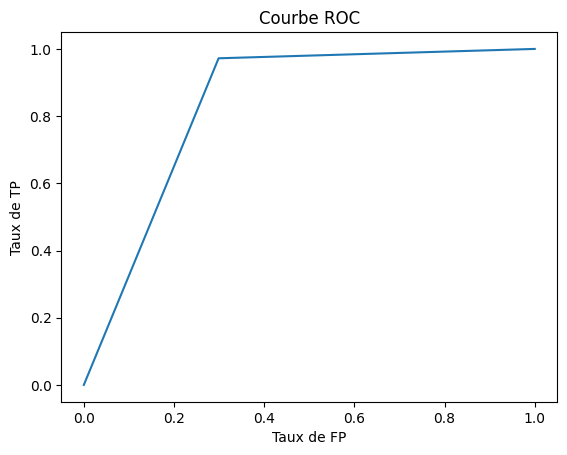

In [89]:
fpr, tpr, _ = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("Taux de FP")
plt.ylabel("Taux de TP")
plt.title("Courbe ROC")
plt.show()

In [90]:
# Évaluation avec les métriques recall, precision et f1-score
print("Classification Report:\n", classification_report(y_test, y_pred2))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.77     31454
           1       0.94      0.97      0.96    147980

    accuracy                           0.92    179434
   macro avg       0.89      0.84      0.86    179434
weighted avg       0.92      0.92      0.92    179434



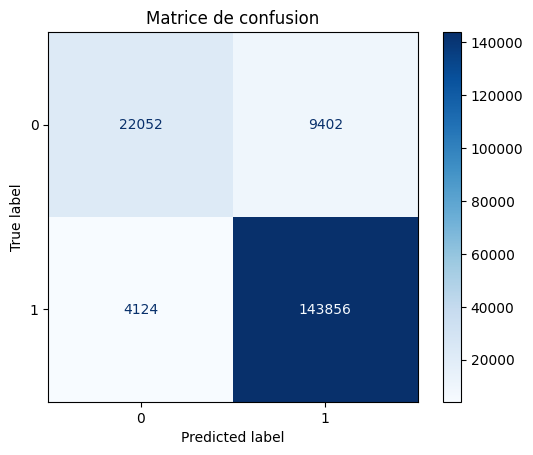

In [91]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title('Matrice de confusion')
plt.show()